In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import filters, exposure
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score, accuracy_score
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import cv2
from sklearn.model_selection import train_test_split
import time

# Partie 1 : Stratégie d’élaboration d’un modèle et traitement des images

## 1) Chargement des données

In [2]:
image_folder = 'Flipkart/Images'
csv_file = 'Flipkart/flipkart_com-ecommerce_sample_1050.csv'

In [3]:
# Charger les données du fichier CSV
def load_data(csv_file):
    data = pd.read_csv(csv_file, sep=",")
    data = data[["uniq_id", "product_name", "product_category_tree"]]
    data["product_category_tree"].replace(to_replace=r'[\["\]]', value="", regex=True, inplace=True)
    category = data["product_category_tree"].str.split(" >> ", expand=True)
    category.rename(columns={0: "Categorie", 1: "Sous-categorie 1"}, inplace=True)
    data = data.merge(category[["Categorie", "Sous-categorie 1"]], how="inner", on=category.index)
    data['uniq_id_clean'] = data['uniq_id'].str.strip().str.lower()
    return data


In [4]:
# Charger les données
data = load_data(csv_file)

/var/folders/hy/g05wz4ln30z1r5z3mv1rwd2h0000gn/T/ipykernel_73884/2919505949.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["product_category_tree"].replace(to_replace=r'[\["\]]', value="", regex=True, inplace=True)


## 2) Préparation des images avec des transformations améliorées

In [5]:
def preprocess_image(image_path):
    img = Image.open(image_path).convert('L')  # Convertir en niveaux de gris
    img = np.array(img)
    
    # Réduire le bruit avec un filtre gaussien
    img_filtered = filters.gaussian(img, sigma=1)
    
    # Améliorer le contraste avec l'égalisation d'histogramme
    img_eq = exposure.equalize_hist(img_filtered)
    
    # Rééchelonner l'intensité pour étirer la plage dynamique
    img_rescale = exposure.rescale_intensity(img_eq, in_range='image', out_range=(0, 255))
    
    return Image.fromarray(img_rescale.astype(np.uint8))

In [6]:
# Lister les fichiers d'images
image_files = os.listdir(image_folder)

In [7]:
# Filtrer les images disponibles dans le dossier d'images
image_files_no_ext = [os.path.splitext(file)[0].lower() for file in image_files]
data = data[data['uniq_id_clean'].isin(image_files_no_ext)]

# Partie 2 : Séparation des ensembles d'entraînement et de test

In [8]:
# Séparation des données en train/test (80% pour l'entraînement, 20% pour le test)
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42, stratify=data['Categorie'])

In [9]:
# Liste des fichiers d'images pour chaque ensemble
train_image_files = [f"{file}.jpg" for file in train_set['uniq_id_clean']]
test_image_files = [f"{file}.jpg" for file in test_set['uniq_id_clean']]

# Partie 3 : Modèle simple (ORB) avec séparation train/test

In [10]:
# Extraction des descripteurs ORB
def extract_orb_features(image_files, image_folder):
    all_descriptors = []
    image_descriptors = []
    for image_file in tqdm(image_files, desc="Extraction des descripteurs ORB"):
        img_path = os.path.join(image_folder, image_file)
        img = preprocess_image(img_path)
        
        # Initialiser ORB
        orb = cv2.ORB_create(nfeatures=500)  # Ajuster nfeatures pour détecter plus de points d'intérêt
        
        # Détecter les points d'intérêt et calculer les descripteurs
        kp, des = orb.detectAndCompute(np.array(img), None)
        
        if des is not None:
            des_mean = np.mean(des, axis=0)  # Prendre la moyenne des descripteurs
            all_descriptors.append(des_mean)
            image_descriptors.append(image_file)
    
    return np.array(all_descriptors), image_descriptors

In [11]:
# Extraction des features ORB pour train et test
orb_features_train, orb_image_descriptors_train = extract_orb_features(train_image_files, image_folder)
orb_features_test, orb_image_descriptors_test = extract_orb_features(test_image_files, image_folder)

Extraction des descripteurs ORB:  90%|████████▉ | 755/840 [01:20<00:06, 14.00it/s]/opt/anaconda3/envs/DS_PROJET_6/lib/python3.11/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Extraction des descripteurs ORB: 100%|██████████| 210/210 [00:22<00:00,  9.42it/s]


In [12]:
# Application du clustering et du t-SNE
def apply_tsne_and_clustering(features, image_descriptors, n_clusters=7):
    pca = PCA(n_components=20)
    features_pca = pca.fit_transform(features)
    
    tsne = TSNE(n_components=2, random_state=0)
    features_tsne = tsne.fit_transform(features_pca)
    
    descriptors_tsne_df = pd.DataFrame(features_tsne, columns=['tsne1', 'tsne2'])
    descriptors_tsne_df['image_file'] = image_descriptors
    descriptors_tsne_df['image_file_no_ext'] = descriptors_tsne_df['image_file'].str.replace('.jpg', '').str.replace('.png', '').str.strip().str.lower()
    
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=0)
    descriptors_tsne_df['kmeans_labels'] = kmeans.fit_predict(features_tsne)
    
    return descriptors_tsne_df

In [13]:
# Application du t-SNE et du clustering sur le jeu d'entraînement
orb_descriptors_tsne_train = apply_tsne_and_clustering(orb_features_train, orb_image_descriptors_train)

/opt/anaconda3/envs/DS_PROJET_6/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/DS_PROJET_6/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [14]:
# Calcul de l'ARI (Adjusted Rand Index)
def calculate_ari(descriptors_tsne_df, data):
    # Création d'un dictionnaire qui mappe chaque fichier d'image à sa vraie catégorie
    file_to_category = {row['uniq_id_clean']: row['Categorie'] for _, row in data.iterrows()}
    
    # Associer les vraies catégories aux images en se basant sur le nom de fichier
    descriptors_tsne_df['true_labels'] = descriptors_tsne_df['image_file_no_ext'].map(file_to_category)
    
    # Supprimer les lignes avec des valeurs manquantes (si certaines images ne sont pas dans le CSV par exemple)
    descriptors_tsne_df = descriptors_tsne_df.dropna(subset=['true_labels'])
    
    # Encoder les vraies étiquettes sous forme numérique pour calculer l'ARI
    label_encoder = LabelEncoder()
    true_labels_encoded = label_encoder.fit_transform(descriptors_tsne_df['true_labels'])
    
    # Calcul de l'ARI entre les étiquettes réelles et les clusters prédits par KMeans
    ari = adjusted_rand_score(true_labels_encoded, descriptors_tsne_df['kmeans_labels'])
    
    return ari, descriptors_tsne_df

In [15]:
# Calcul de l'ARI pour ORB
ari_orb_train, orb_descriptors_tsne_train = calculate_ari(orb_descriptors_tsne_train, train_set)
print(f"ARI pour la méthode basique (ORB) sur le train_set : {ari_orb_train}")

ARI pour la méthode basique (ORB) sur le train_set : 0.033894318599223656


In [16]:
# Application du t-SNE et du clustering sur le jeu de test
orb_descriptors_tsne_test = apply_tsne_and_clustering(orb_features_test, orb_image_descriptors_test)
ari_orb_test, orb_descriptors_tsne_test = calculate_ari(orb_descriptors_tsne_test, test_set)
print(f"ARI pour la méthode basique (ORB) sur le test_set : {ari_orb_test}")

/opt/anaconda3/envs/DS_PROJET_6/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/DS_PROJET_6/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


ARI pour la méthode basique (ORB) sur le test_set : 0.0032625344221608277


# Partie 4 : Modèle avancé (VGG16) avec Transfer Learning

In [17]:
# Extraction des features avec VGG16
def extract_vgg16_features(image_files, image_folder):
    base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
    images_features = []
    image_descriptors = []
    for image_file in tqdm(image_files, desc="Extraction des features VGG16"):
        img_path = os.path.join(image_folder, image_file)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        features = base_model.predict(image, verbose=0)
        images_features.append(features.flatten())
        image_descriptors.append(image_file)
    return np.array(images_features), image_descriptors

In [18]:
# Extraction des features VGG16 pour train et test
vgg16_features_train, vgg16_image_descriptors_train = extract_vgg16_features(train_image_files, image_folder)
vgg16_features_test, vgg16_image_descriptors_test = extract_vgg16_features(test_image_files, image_folder)

Extraction des features VGG16:  90%|█████████ | 756/840 [01:57<00:13,  6.04it/s]/opt/anaconda3/envs/DS_PROJET_6/lib/python3.11/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Extraction des features VGG16: 100%|██████████| 210/210 [00:34<00:00,  6.02it/s]


In [19]:
# Application du t-SNE et du clustering sur le jeu d'entraînement
vgg16_descriptors_tsne_train = apply_tsne_and_clustering(vgg16_features_train, vgg16_image_descriptors_train)

/opt/anaconda3/envs/DS_PROJET_6/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/DS_PROJET_6/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [20]:
# Calcul de l'ARI pour VGG16 sur train_set
ari_vgg16_train, vgg16_descriptors_tsne_train = calculate_ari(vgg16_descriptors_tsne_train, train_set)
print(f"ARI pour la méthode avancée (VGG16) sur le train_set : {ari_vgg16_train}")

ARI pour la méthode avancée (VGG16) sur le train_set : 0.4578457468149762


In [21]:
# Application du t-SNE et du clustering sur le jeu de test
vgg16_descriptors_tsne_test = apply_tsne_and_clustering(vgg16_features_test, vgg16_image_descriptors_test)

/opt/anaconda3/envs/DS_PROJET_6/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/DS_PROJET_6/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [22]:
# Calcul de l'ARI pour VGG16 sur test_set
ari_vgg16_test, vgg16_descriptors_tsne_test = calculate_ari(vgg16_descriptors_tsne_test, test_set)
print(f"ARI pour la méthode avancée (VGG16) sur le test_set : {ari_vgg16_test}")

ARI pour la méthode avancée (VGG16) sur le test_set : 0.29786456776593273


# Partie 5 : Visualisation des t-SNE pour ORB et VGG16

In [23]:
# Visualisation du t-SNE des clusters prédits par KMeans pour ORB
def visualize_tsne(descriptors_tsne_df, method_name):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='tsne1', y='tsne2', hue='kmeans_labels', data=descriptors_tsne_df, palette='viridis')
    plt.title(f't-SNE des descripteurs {method_name} avec K-Means (Labels Prédits)')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

    # Visualisation des vraies catégories
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='tsne1', y='tsne2', hue='true_labels', data=descriptors_tsne_df, palette='viridis')
    plt.title(f't-SNE des descripteurs {method_name} avec K-Means (Vraies Catégories)')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()


Visualisation t-SNE pour ORB


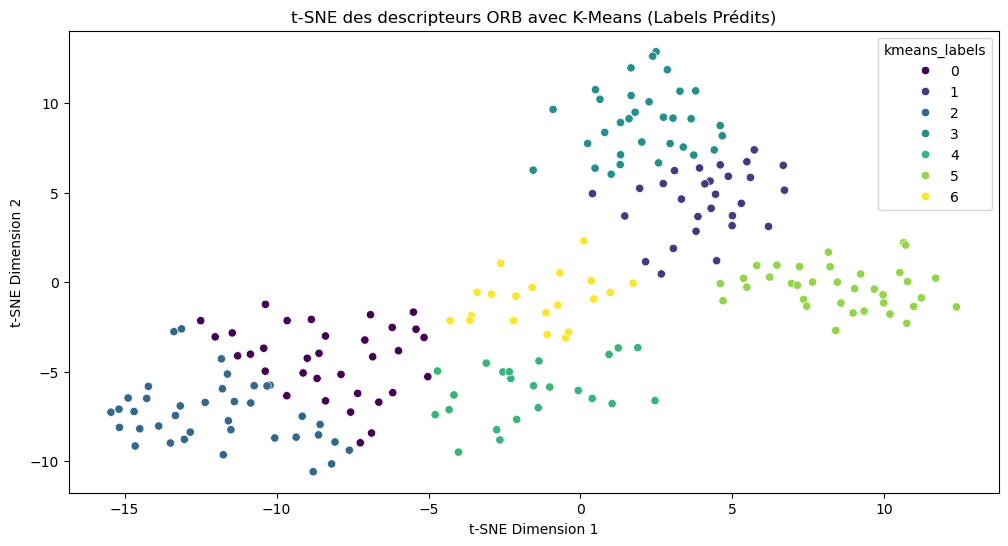

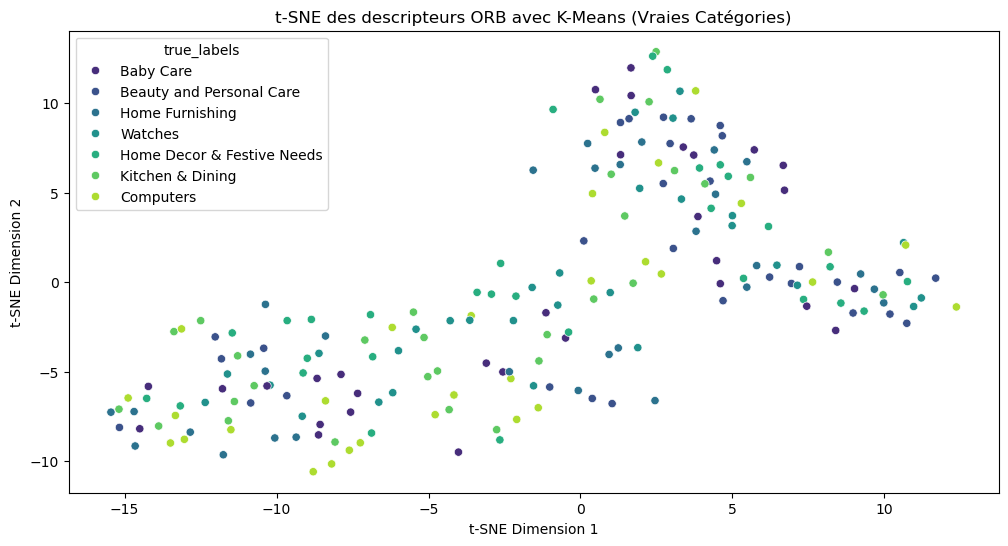

In [24]:
# Visualisation des résultats t-SNE pour ORB
print("\nVisualisation t-SNE pour ORB")
visualize_tsne(orb_descriptors_tsne_test, 'ORB')


Visualisation t-SNE pour VGG16


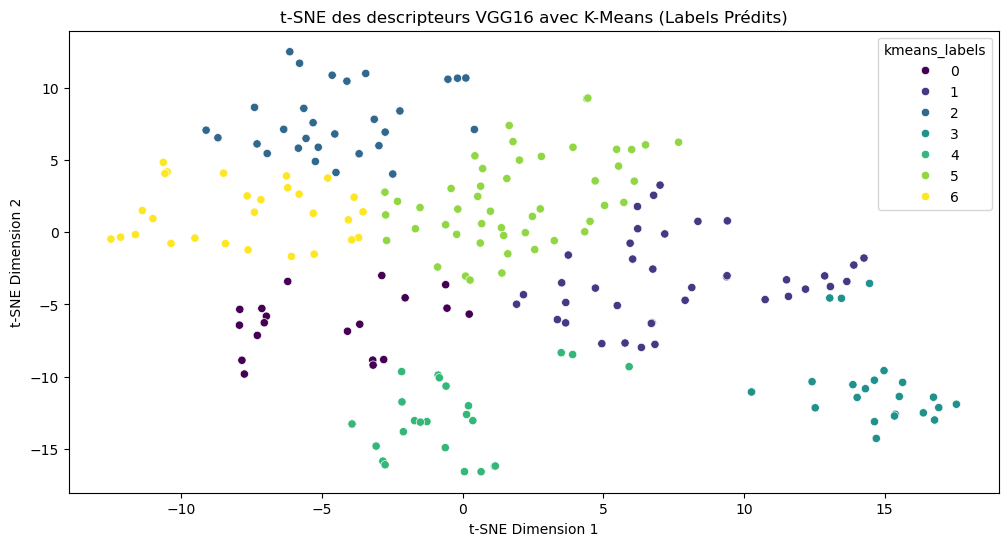

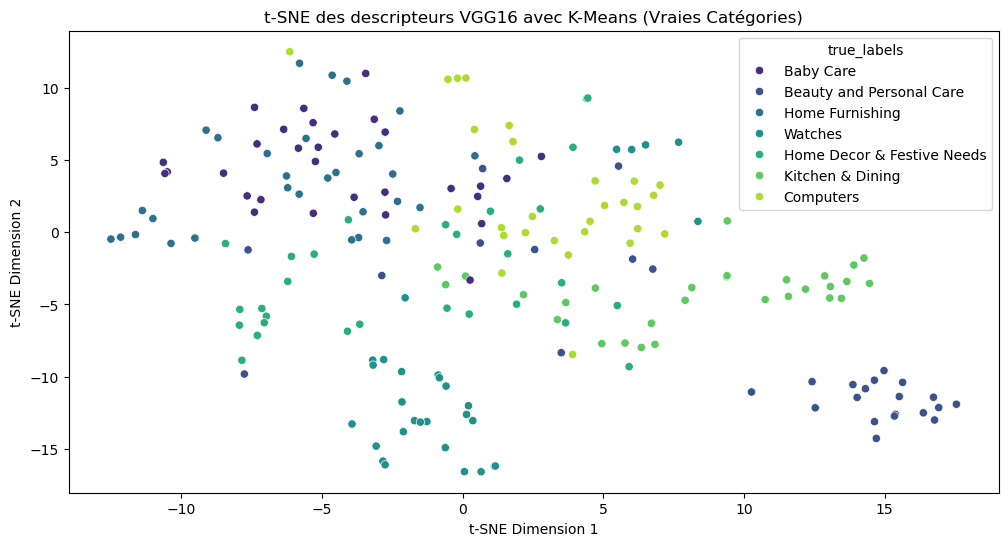

In [25]:
# Visualisation des résultats t-SNE pour VGG16
print("\nVisualisation t-SNE pour VGG16")
visualize_tsne(vgg16_descriptors_tsne_test, 'VGG16')

# Partie 6 : Comparaison des résultats

In [26]:
# Comparaison des ARI entre les deux méthodes
comparison_df = pd.DataFrame({
    'Méthode': ['Basique (ORB)', 'Avancée (VGG16)'],
    'ARI Train': [ari_orb_train, ari_vgg16_train],
    'ARI Test': [ari_orb_test, ari_vgg16_test]
})

In [27]:
# Afficher le tableau comparatif
print("\nTableau comparatif des résultats ARI :")
print(comparison_df)


Tableau comparatif des résultats ARI :
           Méthode  ARI Train  ARI Test
0    Basique (ORB)   0.033894  0.003263
1  Avancée (VGG16)   0.457846  0.297865


/var/folders/hy/g05wz4ln30z1r5z3mv1rwd2h0000gn/T/ipykernel_73884/127889060.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Méthode', y='ARI Test', data=comparison_df, palette='Blues_d')


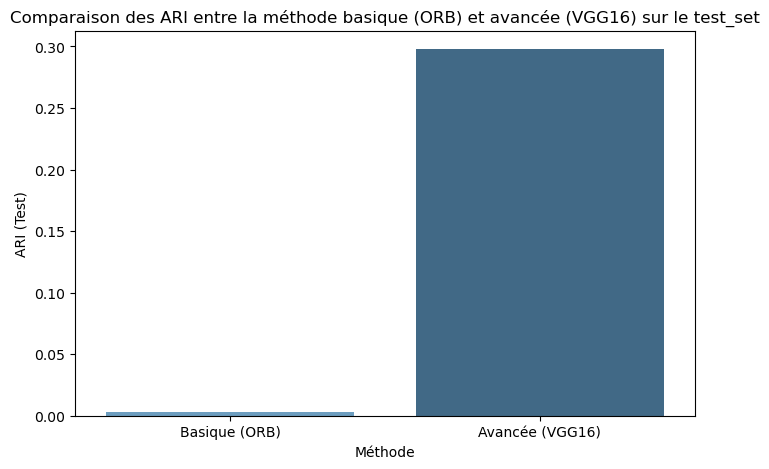

In [28]:
# Visualisation du tableau comparatif
plt.figure(figsize=(8, 5))
sns.barplot(x='Méthode', y='ARI Test', data=comparison_df, palette='Blues_d')
plt.title('Comparaison des ARI entre la méthode basique (ORB) et avancée (VGG16) sur le test_set')
plt.ylabel('ARI (Test)')
plt.show()